# **Experiment Notebook**



In [1]:
# Do not modify this code
!pip install -q utstd

from utstd.ipyrenders import *


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Do not modify this code
import warnings
warnings.simplefilter(action='ignore')

## 0. Import Packages

In [3]:
# <Student to fill this section>
import json
from api_helper_saurabh.data.sets import fetch_api_v0, fetch_api_v1

import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

In [4]:
# pip install api_helper_saurabh

In [5]:
# pip install xgboost

---
## A. Project Description


In [6]:
# <Student to fill this section>
student_name = "Saurabh Sabharwal"
student_id = "25606169"

In [7]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [8]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

---
## B. Business Understanding

In [124]:
# <Student to fill this section>
business_use_case_description = """
TTO find the cumulative amount of rain in the next 3 days
"""

In [125]:
# Do not modify this code
print_tile(size="h3", key='business_use_case_description', value=business_use_case_description)

In [126]:
# <Student to fill this section>
business_objectives = """
Accuracy of results will impact weather reporting.
"""

In [127]:
# Do not modify this code
print_tile(size="h3", key='business_objectives', value=business_objectives)

In [128]:
# <Student to fill this section>
stakeholders_expectations_explanations = """
The results can be used to publish weather update in Sydney. Client for this data and project is weather reporting agencies, and end users are going to be residents of Sydney, farmers, sports authorities (deciding which dates to select for a open-stadium matches)
"""

In [129]:
# Do not modify this code
print_tile(size="h3", key='stakeholders_expectations_explanations', value=stakeholders_expectations_explanations)

---
## C. Data Understanding

### C.1   Load Datasets


#### General

In [15]:
url_api = "https://archive-api.open-meteo.com/v1/archive?latitude=-33.8678&longitude=151.2073&start_date=2022-09-28&end_date=2025-09-28&daily=temperature_2m_mean,temperature_2m_max,temperature_2m_min,sunshine_duration,rain_sum,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_direction_10m_dominant&hourly=temperature_2m,wind_speed_100m,wind_direction_100m,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,vapour_pressure_deficit,rain,precipitation,relative_humidity_2m,surface_pressure,direct_radiation_instant&timezone=Australia%2FSydney&wind_speed_unit=ms&timeformat=unixtime"

In [16]:
url = "https://archive-api.open-meteo.com/v1/archive"

params = {
    "latitude": -33.8678,
    "longitude": 151.2073,
    "start_date": "2015-09-15",
    "end_date": "2025-09-15",   # shorten for test
    "daily": "temperature_2m_mean,temperature_2m_max,temperature_2m_min,sunshine_duration,rain_sum,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_direction_10m_dominant",
    "hourly": "temperature_2m,wind_speed_100m,wind_direction_100m,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,vapour_pressure_deficit,rain,precipitation,relative_humidity_2m,surface_pressure,direct_radiation_instant",
    "timezone": "Australia/Sydney",
    "wind_speed_unit": "ms",
    "timeformat": "unixtime"
}

In [17]:
temp_df = fetch_api_v0(url=url, params=params)

In [18]:
import json

data = json.loads(temp_df.to_json())

In [19]:
hourly_data = pd.DataFrame(data["hourly"])
daily_data = pd.DataFrame(data["daily"])

# Convert time columns from UNIX to datetime
for df in [hourly_data, daily_data]:
    if "time" in df.columns:
        df["time"] = pd.to_datetime(df["time"], unit="s")

In [20]:
print(daily_data.shape)
print(hourly_data.shape)

(3654, 27)
(87696, 27)


In [21]:
print(daily_data.info())
print(hourly_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   time                         3654 non-null   datetime64[ns]
 1   temperature_2m               0 non-null      object        
 2   wind_speed_100m              0 non-null      object        
 3   wind_direction_100m          0 non-null      object        
 4   soil_moisture_0_to_7cm       0 non-null      object        
 5   soil_moisture_7_to_28cm      0 non-null      object        
 6   soil_temperature_0_to_7cm    0 non-null      object        
 7   soil_temperature_7_to_28cm   0 non-null      object        
 8   cloud_cover                  0 non-null      object        
 9   cloud_cover_low              0 non-null      object        
 10  cloud_cover_mid              0 non-null      object        
 11  cloud_cover_high             0 non-null    

In [22]:
cols_to_drop = ['temperature_2m', 'wind_speed_100m', 'wind_direction_100m',
       'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
       'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm',
       'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'vapour_pressure_deficit', 'rain', 'precipitation',
       'relative_humidity_2m', 'surface_pressure', 'direct_radiation_instant']

daily_data.drop(columns=cols_to_drop, inplace=True)
daily_data.shape

(3654, 10)

In [23]:
cols_to_drop = ['temperature_2m_mean', 'temperature_2m_max', 'temperature_2m_min',
       'sunshine_duration', 'rain_sum', 'precipitation_sum',
       'precipitation_hours', 'wind_speed_10m_max',
       'wind_direction_10m_dominant']

hourly_data.drop(columns=cols_to_drop, inplace=True)
hourly_data.shape

(87696, 18)

In [27]:
from pathlib import Path

class AT:
    def __init__(self, folder_path):
        self.folder_path = Path(folder_path)
        self.folder_path.mkdir(parents=True, exist_ok=True)  # <--- ensures folder exists

at = AT("../data/raw/regression")

In [28]:
# to avoid API runtime error, we are storing the daily_df and hourly_df locally
try:
    daily_data.to_csv(at.folder_path / "daily_df.csv", index=False)
    hourly_data.to_csv(at.folder_path / "hourly_df.csv", index=False)
except Exception as e:
    print(e)

#### For the second model, I will be using hourly_df

In [29]:
df = pd.read_csv("../data/raw/regression/hourly_df.csv")

In [30]:
df.head()

,time,temperature_2m,wind_speed_100m,wind_direction_100m,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,vapour_pressure_deficit,rain,precipitation,relative_humidity_2m,surface_pressure,direct_radiation_instant
0,2015-09-14 14:00:00,16.4,5.30,358,0.133,0.178,16.3,17.5,0,0,0,0,0.42,0.0,0.0,77,1012.7,0.0
1,2015-09-14 15:00:00,15.8,4.85,346,0.133,0.178,15.9,17.3,0,0,0,0,0.39,0.0,0.0,78,1012.2,0.0
2,2015-09-14 16:00:00,15.2,4.66,337,0.133,0.178,15.5,17.2,0,0,0,0,0.34,0.0,0.0,80,1011.5,0.0
3,2015-09-14 17:00:00,14.7,5.01,331,0.133,0.178,15.1,17.0,0,0,0,0,0.31,0.0,0.0,81,1010.6,0.0
4,2015-09-14 18:00:00,14.3,5.64,330,0.133,0.178,14.7,16.8,0,0,0,0,0.31,0.0,0.0,81,1010.2,0.0


In [31]:
df.tail()

,time,temperature_2m,wind_speed_100m,wind_direction_100m,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,vapour_pressure_deficit,rain,precipitation,relative_humidity_2m,surface_pressure,direct_radiation_instant
87691,2025-09-15 09:00:00,19.2,8.70,322,0.197,0.248,18.5,16.8,0,0,0,0,1.02,0.0,0.0,54,1010.7,0.0
87692,2025-09-15 10:00:00,18.4,8.54,319,0.197,0.247,17.3,16.8,0,0,0,0,0.97,0.0,0.0,54,1011.0,0.0
87693,2025-09-15 11:00:00,17.6,8.15,312,0.197,0.247,16.4,16.7,10,0,0,10,0.88,0.0,0.0,56,1011.2,0.0
87694,2025-09-15 12:00:00,16.4,7.19,322,0.197,0.246,15.5,16.6,6,0,0,6,0.74,0.0,0.0,60,1010.8,0.0
87695,2025-09-15 13:00:00,16.0,8.27,338,0.201,0.246,15.3,16.4,22,0,0,22,0.70,0.0,0.0,62,1010.9,0.0


In [32]:
# Ensure 'time' column is datetime
df['time'] = pd.to_datetime(df['time'])

# Keep only rows where date is before 2025-01-01
hourly_df = df[df['time'] < '2025-01-01']

In [33]:
test_2025 = df[df['time'] > '2025-01-01'] # to be used later for the final predictions

In [34]:
hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81514 entries, 0 to 81513
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   time                        81514 non-null  datetime64[ns]
 1   temperature_2m              81514 non-null  float64       
 2   wind_speed_100m             81514 non-null  float64       
 3   wind_direction_100m         81514 non-null  int64         
 4   soil_moisture_0_to_7cm      81514 non-null  float64       
 5   soil_moisture_7_to_28cm     81514 non-null  float64       
 6   soil_temperature_0_to_7cm   81514 non-null  float64       
 7   soil_temperature_7_to_28cm  81514 non-null  float64       
 8   cloud_cover                 81514 non-null  int64         
 9   cloud_cover_low             81514 non-null  int64         
 10  cloud_cover_mid             81514 non-null  int64         
 11  cloud_cover_high            81514 non-null  int64         


In [35]:
hourly_df.describe()

,time,temperature_2m,wind_speed_100m,wind_direction_100m,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,vapour_pressure_deficit,rain,precipitation,relative_humidity_2m,surface_pressure,direct_radiation_instant
count,81514,81514.000000,81514.000000,81514.000000,81514.000000,81514.000000,81514.000000,81514.000000,81514.000000,81514.000000,81514.000000,81514.000000,81514.000000,81514.000000,81514.000000,81514.000000,81514.000000,81514.000000
mean,2020-05-08 18:30:00,17.500036,5.873650,182.247786,0.177349,0.180835,18.382807,18.256262,48.641240,22.534006,23.497706,25.692629,0.606428,0.111816,0.111816,73.106239,1010.967174,137.210925
min,2015-09-14 14:00:00,0.900000,0.000000,0.000000,0.017000,0.052000,3.400000,7.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,980.900000,0.000000
25%,2018-01-10 16:15:00,13.700000,3.820000,84.000000,0.118000,0.132000,14.000000,14.200000,5.000000,0.000000,0.000000,0.000000,0.230000,0.000000,0.000000,62.000000,1006.300000,0.000000
50%,2020-05-08 18:30:00,17.700000,5.610000,186.000000,0.178000,0.177000,18.300000,18.500000,44.000000,4.000000,6.000000,0.000000,0.480000,0.000000,0.000000,75.000000,1011.100000,0.000000
75%,2022-09-04 20:45:00,21.100000,7.680000,268.750000,0.233000,0.228000,22.200000,21.900000,95.000000,33.000000,37.000000,52.000000,0.830000,0.000000,0.000000,87.000000,1015.800000,218.100000
max,2024-12-31 23:00:00,41.800000,20.580000,360.000000,0.403000,0.402000,42.000000,30.100000,100.000000,100.000000,100.000000,100.000000,6.700000,19.700000,19.700000,100.000000,1032.700000,999.900000
std,NaN,5.271054,2.794329,103.444977,0.072116,0.062562,5.621522,4.452012,39.966217,32.497193,32.208234,38.710791,0.536108,0.516521,0.516521,16.888649,6.952612,221.291879


### C.2 Define Target variable

In [36]:
target = 'precipitation_3d'

In [37]:
# Create target variable: cumulated precipitation over next 3 days (72 hours)
hourly_df[target] = hourly_df['precipitation'].rolling(window=72, min_periods=1).sum().shift(-72)

# drop last 72 rows since target will be NaN for them
hourly_df = hourly_df.iloc[:-72]

In [38]:
hourly_df.shape

(81442, 19)

In [39]:
hourly_df.tail()

,time,temperature_2m,wind_speed_100m,wind_direction_100m,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,vapour_pressure_deficit,rain,precipitation,relative_humidity_2m,surface_pressure,direct_radiation_instant,precipitation_3d
81437,2024-12-28 19:00:00,16.9,3.96,274,0.050,0.150,18.0,24.0,0,0,0,0,0.14,0.0,0.0,93,1006.0,0.0,0.3
81438,2024-12-28 20:00:00,18.1,4.55,262,0.050,0.150,18.3,23.7,0,0,0,0,0.26,0.0,0.0,88,1007.0,97.2,0.3
81439,2024-12-28 21:00:00,20.0,3.82,256,0.050,0.149,19.7,23.5,0,0,0,0,0.68,0.0,0.0,71,1008.0,292.2,0.3
81440,2024-12-28 22:00:00,23.0,3.39,254,0.049,0.149,22.0,23.4,0,0,0,0,1.58,0.0,0.0,44,1008.6,506.7,0.3
81441,2024-12-28 23:00:00,25.5,3.10,232,0.048,0.149,24.9,23.4,0,0,0,0,2.28,0.0,0.0,30,1008.4,697.9,0.3


In [40]:
# <Student to fill this section>
target_definition_explanations = """
Target contains binary response, whether it will rain on (t+7)th day or not. Considering only those values as rain where there's more than 1mm of rain_sum. Last 7 records are deleted because they don't have any information of (t+7)th day
"""

In [41]:
# Do not modify this code
print_tile(size="h3", key='target_definition_explanations', value=target_definition_explanations)

### C.3 Explore Target variable

Target Summary Statistics:
count    81442.000000
mean         8.057076
std         15.782435
min          0.000000
25%          0.300000
50%          2.300000
75%          8.600000
max        223.400000
Name: precipitation_3d, dtype: float64


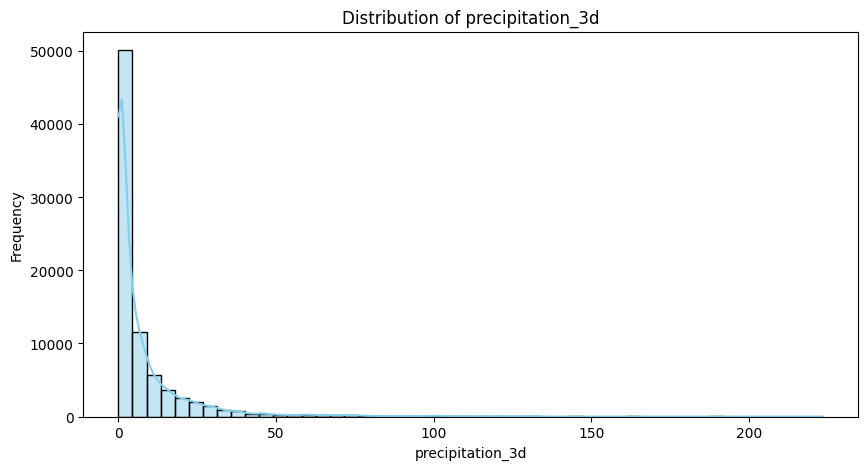

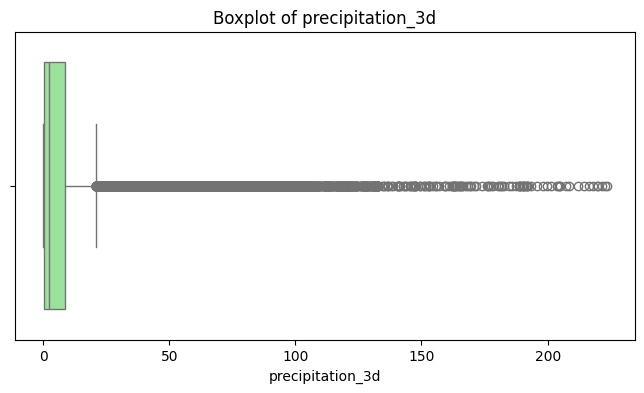

In [42]:
# Basic statistics
print("Target Summary Statistics:")
print(hourly_df[target].describe())

# Distribution plot
plt.figure(figsize=(10, 5))
sns.histplot(hourly_df[target], bins=50, kde=True, color='skyblue')
plt.title(f'Distribution of {target}')
plt.xlabel(target)
plt.ylabel('Frequency')
plt.show()

# Boxplot for outlier detection
plt.figure(figsize=(8, 4))
sns.boxplot(x=hourly_df[target], color='lightgreen')
plt.title(f'Boxplot of {target}')
plt.show()

In [43]:
# <Student to fill this section>
target_distribution_explanations = """
The target variable's significant right skewness and imbalance are expected, as the most frequent outcome is a zero cumulative volume. A data transformation will be applied to mitigate this skewness, which is essential for optimizing model performance
"""

In [44]:
# Do not modify this code
print_tile(size="h3", key='target_distribution_explanations', value=target_distribution_explanations)

### C.4 Explore Feature of Interest - Soil Moisture and Soil Temperature

In [45]:
def explore_features(df, features, target):
    for col in features:
        print(f"\n=== {col} ===")
        print(df[col].describe())
        plt.figure(figsize=(12,4))
        
        # Distribution
        plt.subplot(1,2,1)
        sns.histplot(df[col], bins=50, kde=True, color='skyblue')
        plt.title(f'Distribution of {col}')
        
        # Relationship with target
        plt.subplot(1,2,2)
        sns.scatterplot(x=df[col], y=df[target], alpha=0.5)
        plt.title(f'{col} vs {target}')
        plt.xlabel(col)
        plt.ylabel(target)
        
        plt.tight_layout()
        plt.show()


=== soil_moisture_0_to_7cm ===
count    81442.000000
mean         0.177470
std          0.072032
min          0.017000
25%          0.118000
50%          0.178500
75%          0.233000
max          0.403000
Name: soil_moisture_0_to_7cm, dtype: float64


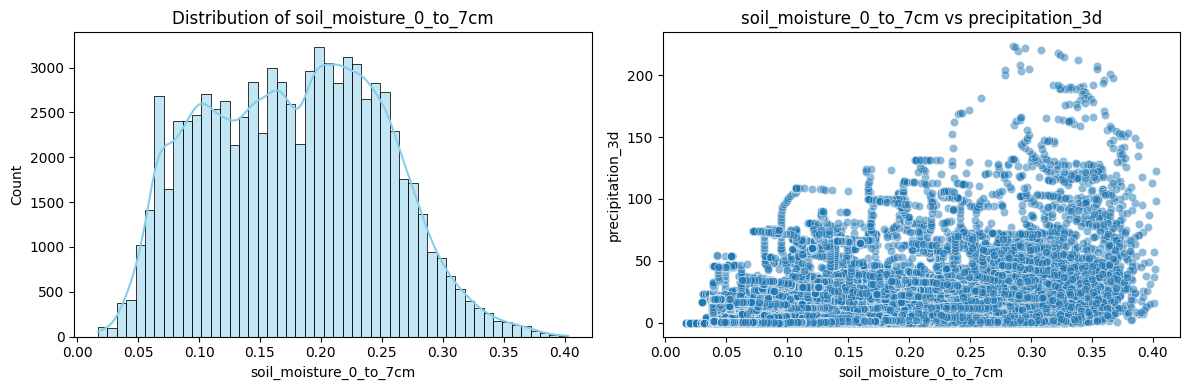


=== soil_moisture_7_to_28cm ===
count    81442.000000
mean         0.180866
std          0.062581
min          0.052000
25%          0.132000
50%          0.177000
75%          0.228000
max          0.402000
Name: soil_moisture_7_to_28cm, dtype: float64


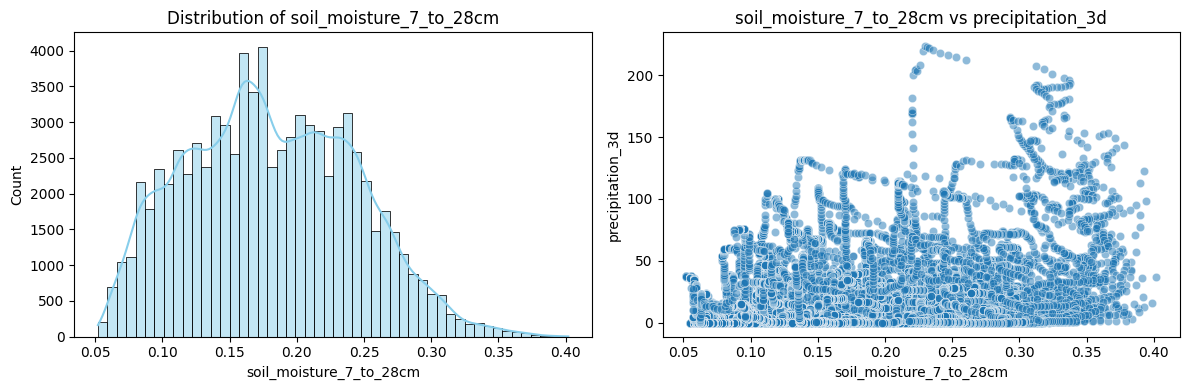


=== soil_temperature_0_to_7cm ===
count    81442.000000
mean        18.375455
std          5.616757
min          3.400000
25%         14.000000
50%         18.300000
75%         22.200000
max         42.000000
Name: soil_temperature_0_to_7cm, dtype: float64


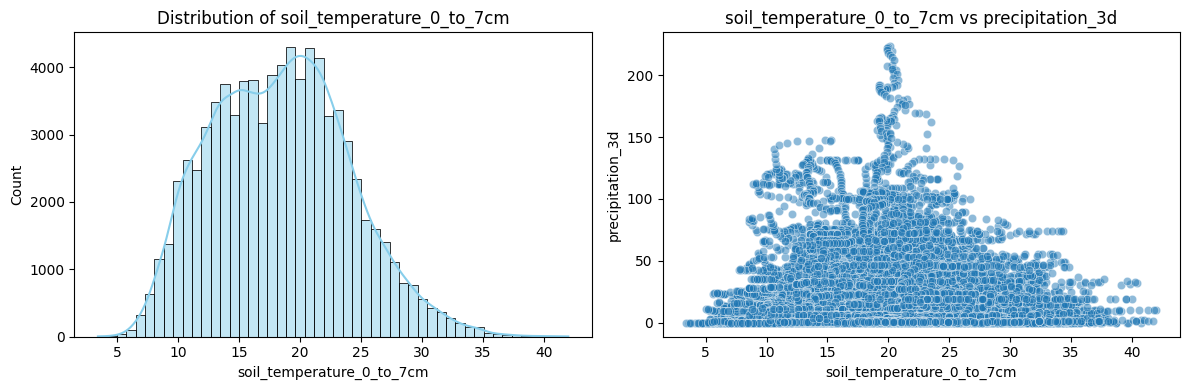


=== soil_temperature_7_to_28cm ===
count    81442.000000
mean        18.250146
std          4.449173
min          7.500000
25%         14.200000
50%         18.400000
75%         21.900000
max         30.100000
Name: soil_temperature_7_to_28cm, dtype: float64


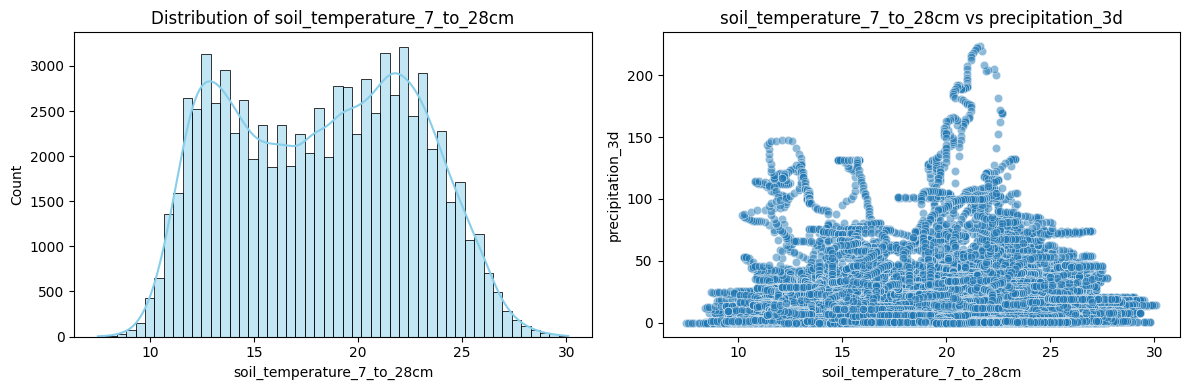

In [46]:
soil_features = ['soil_moisture_0_to_7cm','soil_moisture_7_to_28cm',
                 'soil_temperature_0_to_7cm','soil_temperature_7_to_28cm']

explore_features(hourly_df, soil_features, target)

In [47]:
# <Student to fill this section>
feature_1_insights = """
The soil moisture distributions appear consistent across both depth levels. Regarding temperature, its predictive effect on cumulative volume is concentrated in the mid-range, with the influence being relatively uniform across the remaining temperature spectrum. Furthermore, a positive correlation is observed: higher soil moisture is associated with a greater cumulative volume in the next 3 days, suggesting soil moisture is a direct and significant predictor of impending rainfall.
"""

In [48]:
# Do not modify this code
print_tile(size="h3", key='feature_1_insights', value=feature_1_insights)

### C.5 Explore Feature of Interest - Humidity & Pressure


=== vapour_pressure_deficit ===
count    81442.000000
mean         0.606171
std          0.535946
min          0.000000
25%          0.230000
50%          0.480000
75%          0.830000
max          6.700000
Name: vapour_pressure_deficit, dtype: float64


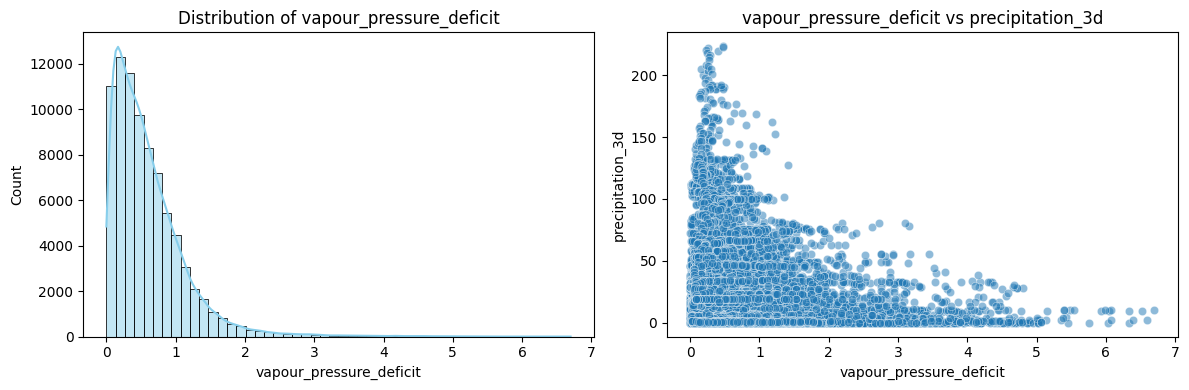


=== relative_humidity_2m ===
count    81442.000000
mean        73.108728
std         16.888516
min          9.000000
25%         62.000000
50%         75.000000
75%         87.000000
max        100.000000
Name: relative_humidity_2m, dtype: float64


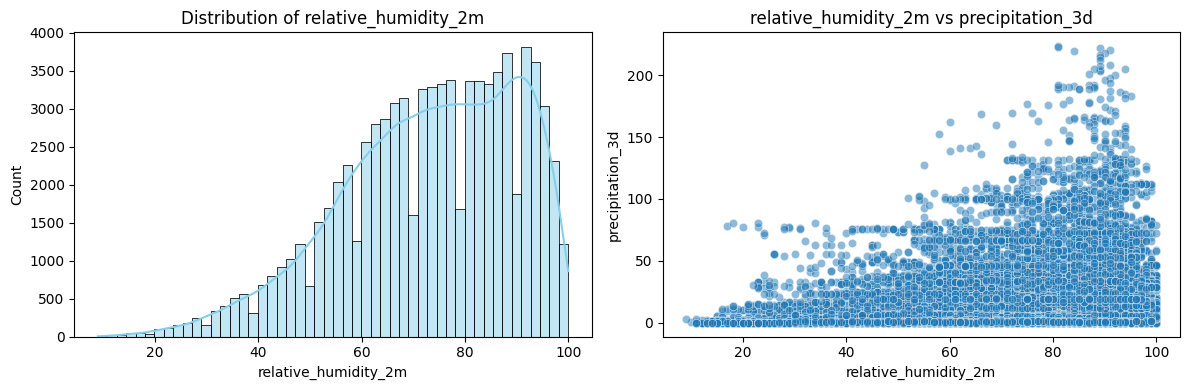


=== surface_pressure ===
count    81442.000000
mean      1010.968308
std          6.955328
min        980.900000
25%       1006.300000
50%       1011.100000
75%       1015.800000
max       1032.700000
Name: surface_pressure, dtype: float64


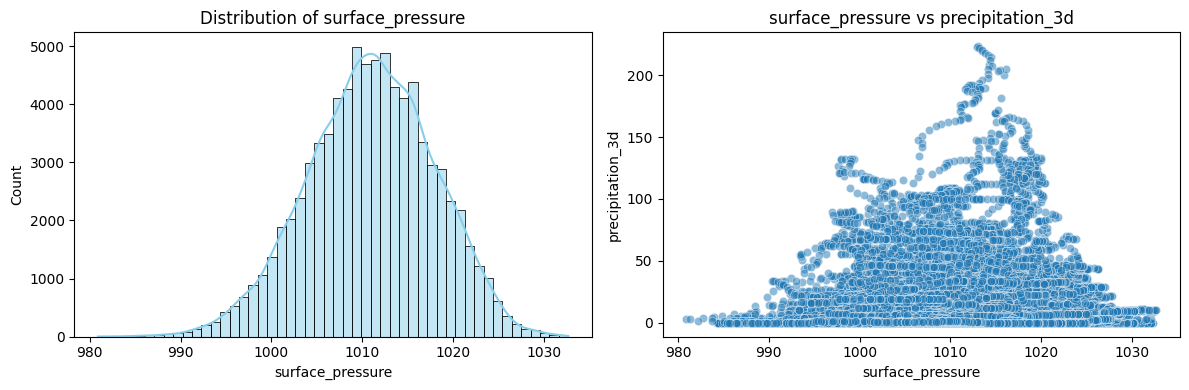


=== direct_radiation_instant ===
count    81442.000000
mean       137.112424
std        221.181983
min          0.000000
25%          0.000000
50%          0.000000
75%        217.900000
max        999.900000
Name: direct_radiation_instant, dtype: float64


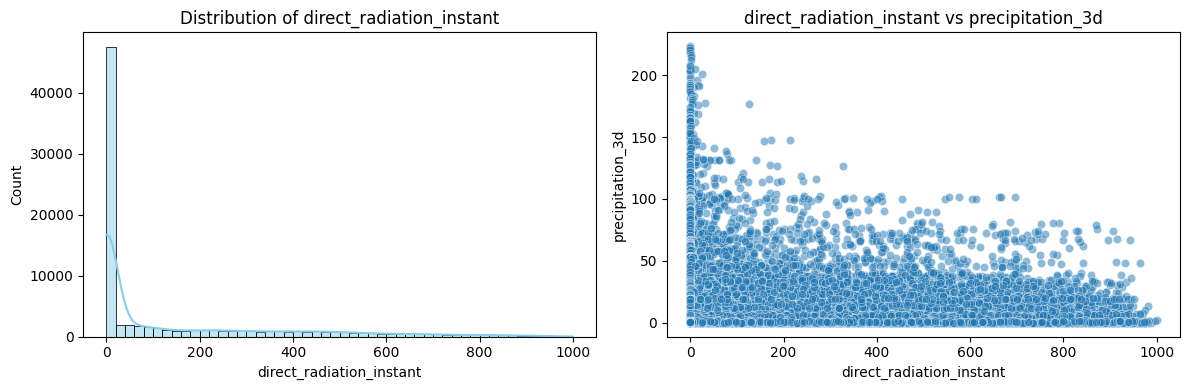

In [49]:
atmosphere_features = ['vapour_pressure_deficit', 'relative_humidity_2m',
                       'surface_pressure','direct_radiation_instant']

explore_features(hourly_df, atmosphere_features, target)

In [50]:
# <Student to fill this section>
feature_2_insights = """
Surface pressure shows a non-linear effect: high pressure suggests increased rain, but extremely high pressure indicates an existing event is subsiding, meaning less future rain. Low direct radiation today, indicative of cloud cover, strongly correlates with higher cumulative rainfall in 3 days. Finally, high humidity and low vapor deficit both positively correlate with a high amount of future rain, signifying a saturated atmosphere.
"""

In [51]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_2_insights)

### C.6 Explore Feature of Interest - Cloud Cover



=== cloud_cover ===
count    81442.000000
mean        48.649063
std         39.968006
min          0.000000
25%          5.000000
50%         44.000000
75%         95.000000
max        100.000000
Name: cloud_cover, dtype: float64


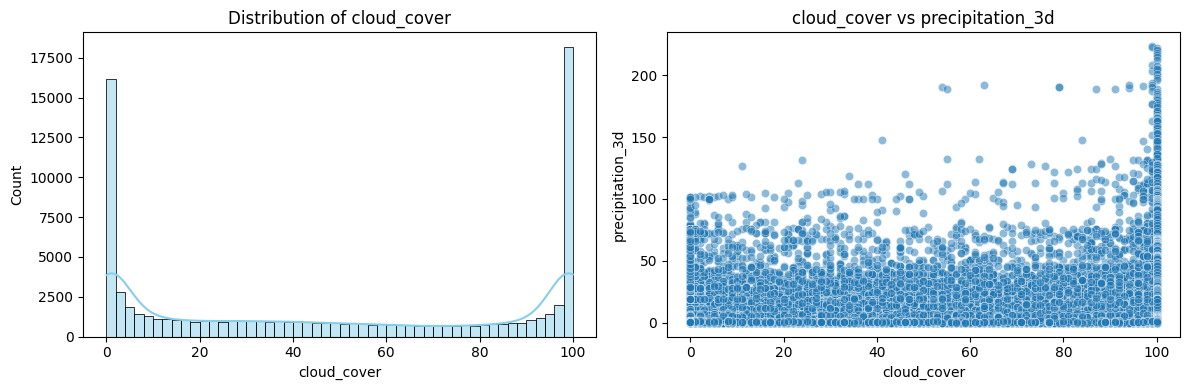


=== cloud_cover_low ===
count    81442.000000
mean        22.538592
std         32.501364
min          0.000000
25%          0.000000
50%          4.000000
75%         34.000000
max        100.000000
Name: cloud_cover_low, dtype: float64


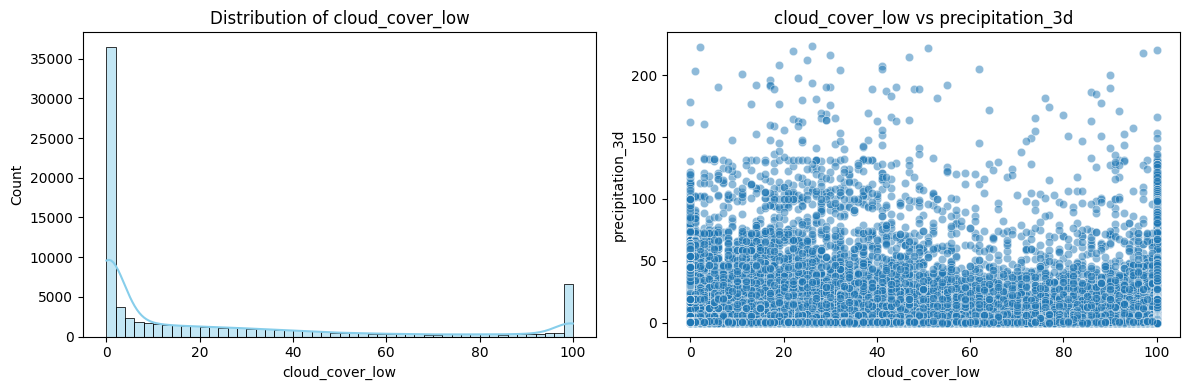


=== cloud_cover_mid ===
count    81442.000000
mean        23.511542
std         32.217378
min          0.000000
25%          0.000000
50%          6.000000
75%         37.000000
max        100.000000
Name: cloud_cover_mid, dtype: float64


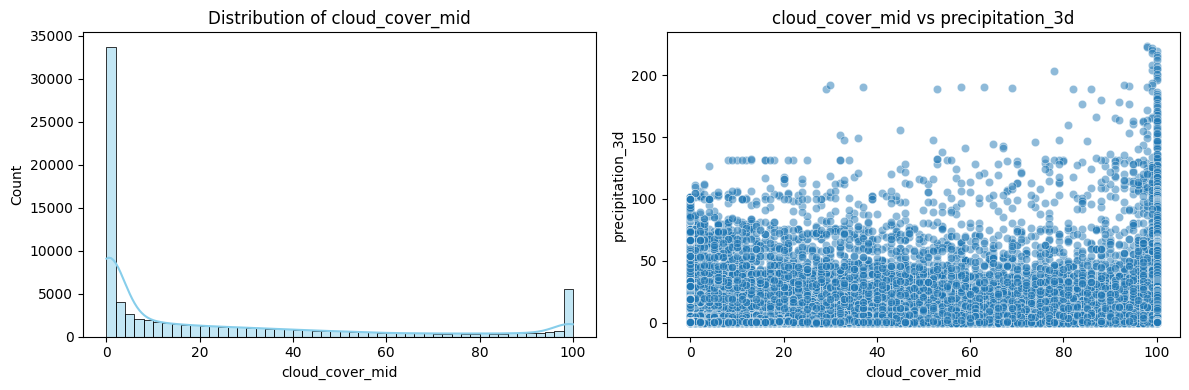


=== cloud_cover_high ===
count    81442.000000
mean        25.698276
std         38.711724
min          0.000000
25%          0.000000
50%          0.000000
75%         52.000000
max        100.000000
Name: cloud_cover_high, dtype: float64


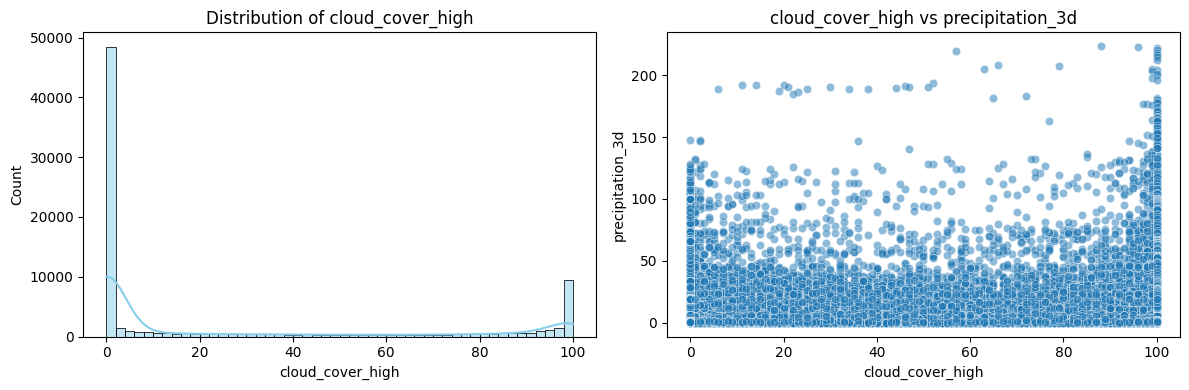

In [52]:
cloud_features = ['cloud_cover','cloud_cover_low','cloud_cover_mid','cloud_cover_high']

explore_features(hourly_df, cloud_features, target)

In [53]:
# <Student to fill this section>
feature_n_insights = """
All cloud cover variables exhibit a bi-modal, U-shaped distribution, with the highest frequency at 0% (clear sky) and 100% (fully overcast), and the median near 0%. Crucially, the scatter plots show that the highest values of cumulative 3-day precipitation (precipitation_3d) are overwhelmingly concentrated when cloud cover approaches 100% at all levels. This strong non-linear relationship confirms high current cloud cover is a powerful predictor for future heavy rainfall.
"""

In [54]:
# Do not modify this code
print_tile(size="h3", key='feature_n_insights', value=feature_n_insights)

---
## D. Feature Selection


### D.1 Correlation Matrix


<Axes: >

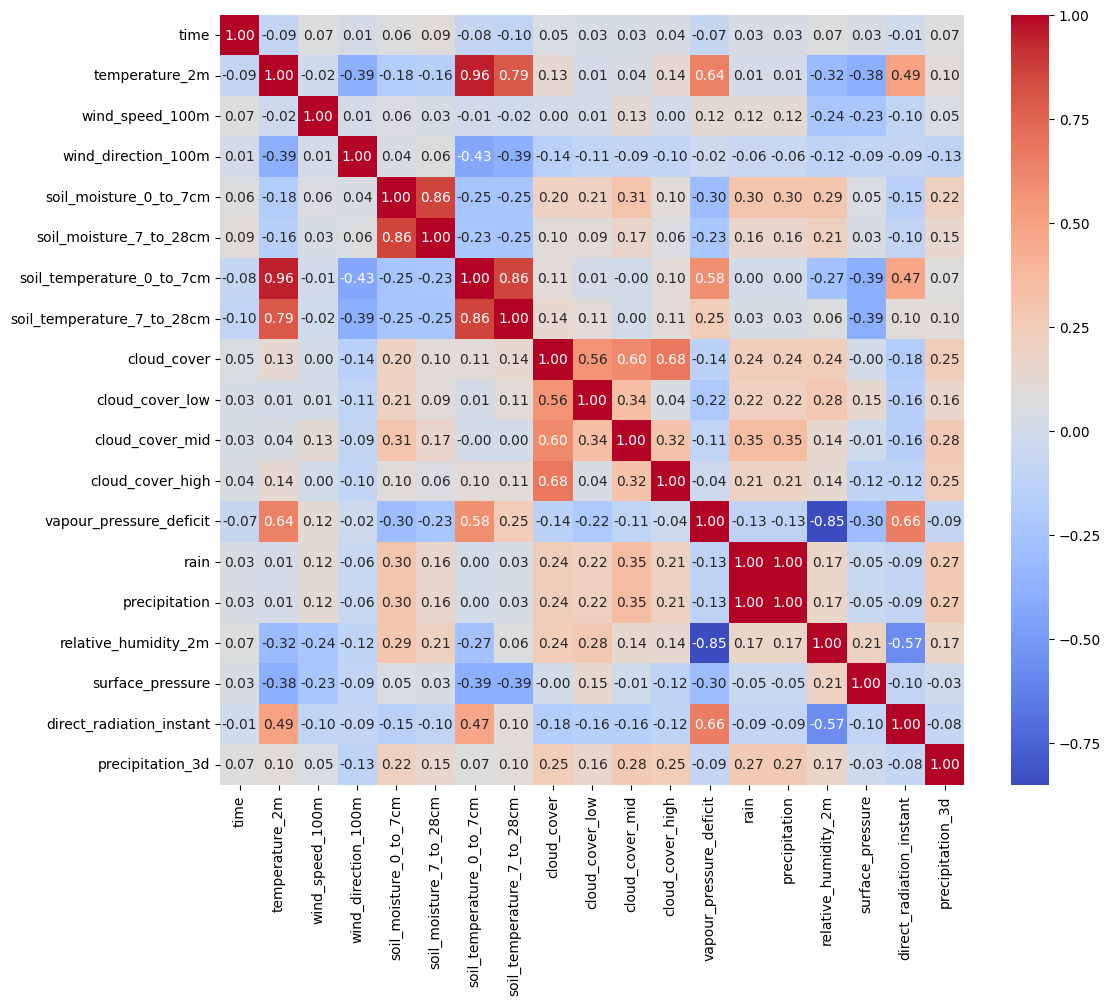

In [55]:
corr = hourly_df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")

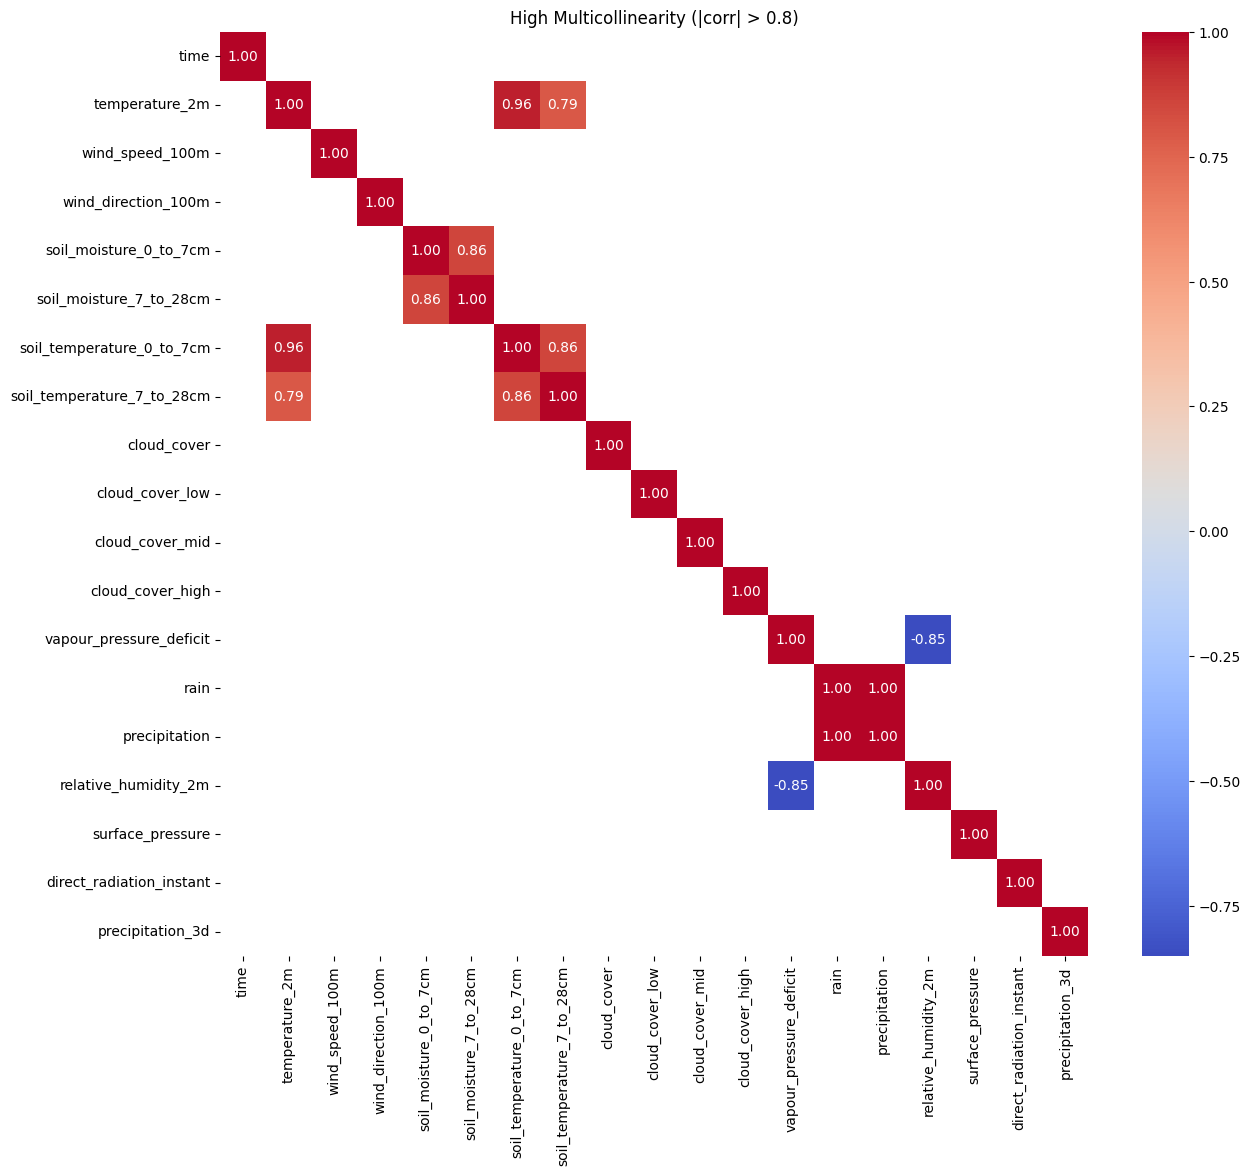

In [56]:
# Focus on multicollinearity (mask weak correlations)
plt.figure(figsize=(14,12))
sns.heatmap(corr[(corr > 0.7) | (corr < -0.7)], annot=True, fmt=".2f", cmap="coolwarm")
plt.title("High Multicollinearity (|corr| > 0.8)")
plt.show()

In [57]:
# <Student to fill this section>
feature_selection_1_insights = """
Multicollinearity is present among several predictor variables. While these collinear features do not exhibit a strong, direct linear relationship with the target variable, their combined or non-linear effects may still be significant. Consequently, we will employ a Random Forest Regressor for Feature Selection to robustly identify which features, including those involved in multicollinearity, contribute most significantly to the predictive power for the target variable.
"""

In [58]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_1_insights', value=feature_selection_1_insights)

### D.2 Feature Selection using Random Forest


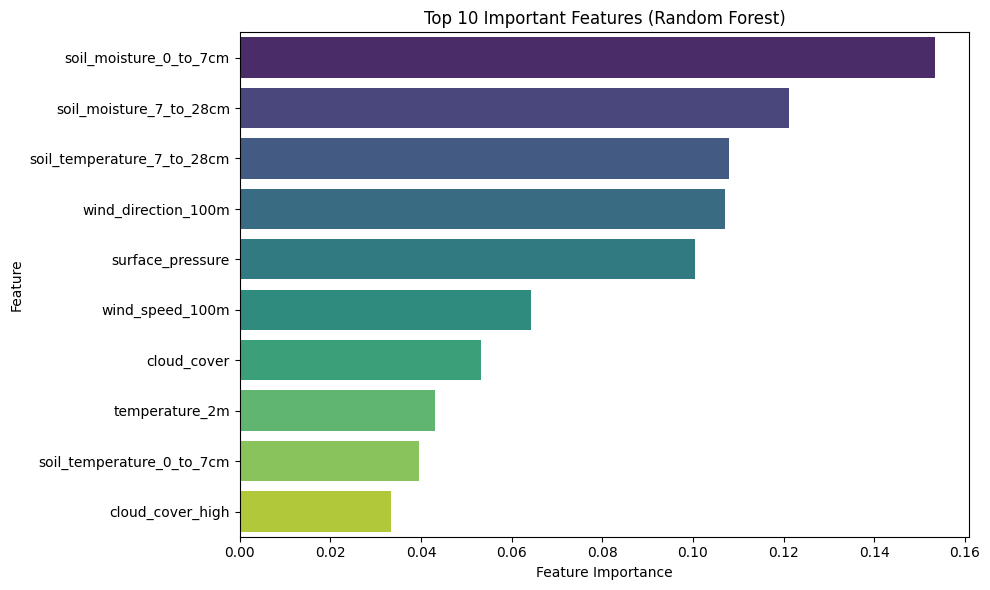

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

to_drop = ['precipitation_3d', 'time']
X = hourly_df.drop(columns=to_drop)
y = hourly_df[target]

# Fit Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1
)

rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Create dataframe for visualization
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select top 10
top10 = feat_importance_df.head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=top10, palette="viridis")
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [60]:
# <Student to fill this section>
feature_selection_2_insights = """
The Random Forest feature selection reveals that soil moisture at both depth levels is the most critical predictor. Following this, soil temperature, wind direction, and surface pressure are the next most important features for forecasting the cumulative volume.
"""

In [61]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_2_insights', value=feature_selection_2_insights)

### D.3 Final Selection of Features

In [62]:
hourly_df.columns

Index(['time', 'temperature_2m', 'wind_speed_100m', 'wind_direction_100m',
       'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
       'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm',
       'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'vapour_pressure_deficit', 'rain', 'precipitation',
       'relative_humidity_2m', 'surface_pressure', 'direct_radiation_instant',
       'precipitation_3d'],
      dtype='object')

In [63]:
features_list = [
    'time', 'wind_speed_100m', 'wind_direction_100m',
    'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
    'soil_temperature_0_to_7cm', 'cloud_cover', 'vapour_pressure_deficit',
    'relative_humidity_2m', 'surface_pressure', 'direct_radiation_instant',
    'precipitation_3d'
]

# removed 'rain', 'precipitation' becasue of data leakage possibility

for features_list = [
    'time', 'wind_speed_100m', 'wind_direction_100m',
    'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
    'soil_temperature_0_to_7cm', 'cloud_cover', 'vapour_pressure_deficit',
    'relative_humidity_2m', 'surface_pressure', 'direct_radiation_instant',
    'precipitation_3d'
]

1. apply log transformation on vapour..., surface_pressure, relative_humidity...., direct_radiation..., target (precipitation_3d)
2. apply min max on cloudcover
3. standard scalar for soil moisture, soil temp, wind speed, wind dir
4. feature engineering on time - day, month, year, hour

- run everything in pipeline
- df name is hourly_df
- use correct names of features, i have just given an example
- in the end just give all the pipelines for transformation, store it somewhere, then we continue with the file later on with modeling pipelines

In [64]:
hourly_df.head()

,time,temperature_2m,wind_speed_100m,wind_direction_100m,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,vapour_pressure_deficit,rain,precipitation,relative_humidity_2m,surface_pressure,direct_radiation_instant,precipitation_3d
0,2015-09-14 14:00:00,16.4,5.30,358,0.133,0.178,16.3,17.5,0,0,0,0,0.42,0.0,0.0,77,1012.7,0.0,4.7
1,2015-09-14 15:00:00,15.8,4.85,346,0.133,0.178,15.9,17.3,0,0,0,0,0.39,0.0,0.0,78,1012.2,0.0,5.0
2,2015-09-14 16:00:00,15.2,4.66,337,0.133,0.178,15.5,17.2,0,0,0,0,0.34,0.0,0.0,80,1011.5,0.0,5.2
3,2015-09-14 17:00:00,14.7,5.01,331,0.133,0.178,15.1,17.0,0,0,0,0,0.31,0.0,0.0,81,1010.6,0.0,5.4
4,2015-09-14 18:00:00,14.3,5.64,330,0.133,0.178,14.7,16.8,0,0,0,0,0.31,0.0,0.0,81,1010.2,0.0,5.4


In [65]:
hourly_df = hourly_df[features_list]

In [66]:
# <Student to fill this section>
feature_selection_explanations = """
Due to the high multicollinearity observed between the atmospheric and soil temperature metrics, temperature_2m variable will be dropped. To maintain parsimony, we will also use only the aggregated cloud_cover instead of its altitude-specific components. Finally, despite their absence from the Top 10 importance list, relative_humidity_2m and vapour_pressure_deficit will be retained as foundational meteorological features.
"""

In [67]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## E. Data Preparation

### E.1 Log transformation

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer

In [69]:
log_features = [
    "vapour_pressure_deficit",
    "surface_pressure",
    "relative_humidity_2m",
    "direct_radiation_instant"
]

target_feature = ["precipitation_3d"]

def log_transform(x):
    return np.log1p(x)  # log(1+x) to avoid log(0)

log_transformer = FunctionTransformer(log_transform, validate=False)

target_transformer = FunctionTransformer(log_transform, validate=False)

In [70]:
# <Student to fill this section>
data_cleaning_1_explanations = """
The Log Transformation will be applied to vapour_pressure_deficit, relative_humidity_2m, surface_pressure, direct_radiation_instant, and the target variable, precipitation_3d. This is necessary because the distributions of these physical parameters and the highly skewed target are often right-tailed, and a log function will help approximate a normal distribution. Normalizing the target is crucial for improving the efficiency and performance of linear regression and other models that assume normally distributed errors.
"""

In [71]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_1_explanations', value=data_cleaning_1_explanations)

### E.2 Standardization

In [72]:
minmax_features = ["cloud_cover"]

standard_features = [
    "soil_moisture_0_to_7cm", "soil_moisture_7_to_28cm",
    "soil_temperature_0_to_7cm", "wind_speed_100m", "wind_direction_100m"
]

In [73]:
standard_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [74]:
# <Student to fill this section>
data_cleaning_2_explanations = """
We will apply MinMaxScaler to the cloud_cover feature, ensuring its values are strictly bounded between 0 and 1. As cloud_cover already represents a physical proportion (percentage of sky covered), MinMax scaling is appropriate to maintain the interpretability of its bounds while preparing it for machine learning algorithms. Furthermore, the rest of the numerical features, including soil_moisture_0_to_7cm, soil_moisture_7_to_28cm, soil_temperature_0_to_7cm, wind_speed_100m, and wind_direction_100m, will be scaled using StandardScaler. This standardizes their distributions to a mean of zero and unit variance, which is essential for distance-based models and for stabilizing gradient descent during training
"""

In [75]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_2_explanations', value=data_cleaning_2_explanations)

### E.3 Feature Engineering

In [76]:
time_feature = ["time"]

In [77]:
def extract_time_features(X):
    # convert to DataFrame and ensure column name
    df = pd.DataFrame(X, columns=["time"])
    df["time"] = pd.to_datetime(df["time"])  # ensure datetime
    return pd.DataFrame({
        "day": df["time"].dt.day,
        "month": df["time"].dt.month,
        "year": df["time"].dt.year,
        "hour": df["time"].dt.hour,
    })

time_transformer = FunctionTransformer(extract_time_features, validate=False)

In [78]:
# <Student to fill this section>
data_cleaning_3_explanations = """
Feature Engineering on the time variable is critical to extract cyclical and positional information for the model. We will decompose the timestamp into discrete components: day, month, year, and hour. These new categorical or ordinal features capture non-linear temporal effects, such as daily cycles, seasonal variations, and long-term trends, providing the model with a richer understanding of the context influencing the 3-day cumulative volume prediction.
"""

In [79]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_3_explanations', value=data_cleaning_3_explanations)

### E.4 Running the pipeline

In [80]:
preprocessor = ColumnTransformer(
    transformers=[
        ("log", Pipeline([("log", log_transformer)]), log_features),
        ("minmax", Pipeline([("minmax", MinMaxScaler())]), minmax_features),
        ("standard", Pipeline([("scaler", StandardScaler())]), standard_features),
        ("time", Pipeline([("time", time_transformer)]), time_feature),
    ],
    remainder="passthrough"  # drop anything not listed
)


# Store pipelines for later modeling
pipelines = {
    "preprocessor": preprocessor,
    "target_transformer": target_transformer
}

In [81]:
def get_feature_names(input_df):
    feature_names = []

    # log features
    feature_names += [f"log_{col}" for col in log_features]

    # minmax scaled features
    feature_names += [f"minmax_{col}" for col in minmax_features]

    # standardized features
    feature_names += [f"scaled_{col}" for col in standard_features]

    # engineered time features
    feature_names += ["day", "month", "year", "hour"]

    # passthrough columns
    passthrough_cols = [
        c for c in input_df.columns 
        if c not in log_features + minmax_features + standard_features + time_feature
    ]
    feature_names += passthrough_cols

    return feature_names

In [82]:
# Fit + transform the df
transformer = preprocessor.fit_transform(hourly_df)

# Get updated feature names
feature_names = get_feature_names(hourly_df)

# Convert back to DataFrame
df_eng = pd.DataFrame(
    transformer,
    columns=feature_names,
    index=hourly_df.index
)

In [83]:
# <Student to fill this section>
data_cleaning_4_explanations = """
All transformations will be consolidated within a preprocessing pipeline for efficiency and consistency. This approach ensures that the sequence of operations—Log Transformation, MinMax/Standard Scaling, and Feature Engineering—is applied correctly and reproducibly to both the training and future test data. The resulting composite pipeline will be stored, allowing for seamless integration with subsequent modeling steps and preventing data leakage and transformation inconsistencies across different phases of the machine learning workflow.
"""

In [84]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_4_explanations', value=data_cleaning_4_explanations)

---
## G. Data Preparation for Modeling

### G.1 Split Datasets

In [85]:
df_eng.head()

,log_vapour_pressure_deficit,log_surface_pressure,log_relative_humidity_2m,log_direct_radiation_instant,minmax_cloud_cover,scaled_soil_moisture_0_to_7cm,scaled_soil_moisture_7_to_28cm,scaled_soil_temperature_0_to_7cm,scaled_wind_speed_100m,scaled_wind_direction_100m,day,month,year,hour,precipitation_3d
0,0.350657,6.921362,4.356709,0.0,0.0,-0.617375,-0.045798,-0.369513,-0.205622,1.698379,14.0,9.0,2015.0,14.0,4.7
1,0.329304,6.920869,4.369448,0.0,0.0,-0.617375,-0.045798,-0.440729,-0.366622,1.582365,14.0,9.0,2015.0,15.0,5.0
2,0.292670,6.920178,4.394449,0.0,0.0,-0.617375,-0.045798,-0.511945,-0.434601,1.495354,14.0,9.0,2015.0,16.0,5.2
3,0.270027,6.919289,4.406719,0.0,0.0,-0.617375,-0.045798,-0.583161,-0.309378,1.437347,14.0,9.0,2015.0,17.0,5.4
4,0.270027,6.918893,4.406719,0.0,0.0,-0.617375,-0.045798,-0.654377,-0.083977,1.427680,14.0,9.0,2015.0,18.0,5.4


In [86]:
# Compute split indices
n = len(df_eng)
train_end = int(0.7 * n)
val_end = int(0.8 * n)  # 70% + 10% = 80%

# Split
train_df = df_eng.iloc[:train_end].reset_index(drop=True)
val_df = df_eng.iloc[train_end:val_end].reset_index(drop=True)
test_df = df_eng.iloc[val_end:].reset_index(drop=True)

In [87]:
# Separate features and target
target_col = target

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]

X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

In [88]:
# Check sizes
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (57009, 14) (57009,)
Validation: (8144, 14) (8144,)
Test: (16289, 14) (16289,)


In [89]:
# <Student to fill this section>
data_splitting_explanations = """
Time-based split preserves sequential order; the model sees past data first.
70/10/20 split: train has majority of data, val for hyperparameter tuning, test for final evaluation.
Resetting the index keeps things clean for downstream processing.
"""

In [90]:
# Do not modify this code
print_tile(size="h3", key='data_splitting_explanations', value=data_splitting_explanations)

### G.2 Transforming 2025 data using pipelines

In [91]:
test_2025 = df[df['time'] > '2025-01-01'] # to be used later for the final predictions

In [92]:
# Create target variable: cumulated precipitation over next 3 days (72 hours)
test_2025[target] = test_2025['precipitation'].rolling(window=72, min_periods=1).sum().shift(-72)
print(test_2025.shape)

# drop last 72 rows since target will be NaN for them
test_2025 = test_2025.iloc[:-72]
print(test_2025.shape)

(6181, 19)
(6109, 19)


In [93]:
test_2025 = test_2025[features_list]

In [94]:
test_2025.shape

(6109, 12)

In [95]:
# Fit + transform the df
test_transformer = preprocessor.fit_transform(test_2025)

# Get updated feature names
feature_names = get_feature_names(test_2025)

# Convert back to DataFrame
test_2025_final = pd.DataFrame(
    test_transformer,
    columns=feature_names,
    index=test_2025.index
)

In [96]:
# Rename columns to match your expected final schema
test_2025_final.columns = [
    'log_vapour_pressure_deficit',
    'log_surface_pressure',
    'log_relative_humidity_2m',
    'log_direct_radiation_instant',
    'minmax_cloud_cover',
    'scaled_soil_moisture_0_to_7cm',
    'scaled_soil_moisture_7_to_28cm',
    'scaled_soil_temperature_0_to_7cm',
    'scaled_wind_speed_100m',
    'scaled_wind_direction_100m',
    'day',
    'month',
    'year',
    'hour',
    'precipitation_3d'
]

In [97]:
# Split features and target
X_test_2025 = test_2025_final.drop(columns=target)
y_test_2025 = test_2025_final[target]

In [98]:
print(X_test_2025.shape)
print(y_test_2025.shape)

(6109, 14)
(6109,)


In [99]:
# <Student to fill this section>
data_transformation_1_explanations = """
Same data transformations are applied to test_2025 data
"""

In [100]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_1_explanations', value=data_transformation_1_explanations)

---
## H. Save Datasets

> Do not change this code

In [101]:
# Do not modify this code
# Save training set
try:
  X_train.to_csv(at.folder_path / 'X_train.csv', index=False)
  y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

  X_val.to_csv(at.folder_path / 'X_val.csv', index=False)
  y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

  X_test.to_csv(at.folder_path / 'X_test.csv', index=False)
  y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
except Exception as e:
  print(e)

In [102]:
# Do not modify this code
# Save training set
try:
  X_test_2025.to_csv(at.folder_path / 'X_test_2025.csv', index=False)
  y_test_2025.to_csv(at.folder_path / 'y_test_2025.csv', index=False)
except Exception as e:
  print(e)

---
## I. Selection of Performance Metrics

> Provide some explanations on why you believe the performance metrics you chose is appropriate


In [103]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to evaluate regression model
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R^2: {r2:.4f}")
    
    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}

# Example usage:
# metrics = evaluate_regression(y_test, y_pred_test)

In [104]:
# <Student to fill this section>
performance_metrics_explanations = """
RMSE, MSE, MAE, R² cover error magnitude and variance explained.

Appropriate for continuous regression target (precipitation_3d).
"""

In [105]:
# Do not modify this code
print_tile(size="h3", key='performance_metrics_explanations', value=performance_metrics_explanations)

## J. Model Training

### J.1 Import Algorithm - Linear Regression

> Provide some explanations on why you believe this algorithm is a good fit


In [106]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [107]:
# <Student to fill this section>
algorithm_selection_explanations = """
Provide some explanations on why you believe this algorithm is a good fit
"""

In [108]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.2 Set Hyperparameters

> Provide some explanations on why you believe this algorithm is a good fit


In [109]:
# Define base pipeline
lr_pipeline = Pipeline([
    ('regressor', LinearRegression())
])

# Hyperparameter grid (example)
lr_param_grid = {
    'regressor__fit_intercept': [True, False],
}

# GridSearchCV
lr_grid = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [110]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
Only the classifier is in the pipeline since features are already transformed.

Tuning uses AUROC because rain/no-rain is likely imbalanced.
"""

In [111]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.3 Fit Model

In [112]:
# Fit on training data
lr_grid.fit(X_train, y_train)

# Best model
best_lr = lr_grid.best_estimator_
print("Best Linear Regression Params:", lr_grid.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Linear Regression Params: {'regressor__fit_intercept': False}


### J.4 Model Technical Performance

> Provide some explanations on model performance


In [113]:
# Predictions
y_train_pred = best_lr.predict(X_train)
y_val_pred = best_lr.predict(X_val)
y_test_pred = best_lr.predict(X_test)

print("Linear Regression Performance (Train):")
evaluate_regression(y_train, y_train_pred)

print("\nLinear Regression Performance (Validation):")
evaluate_regression(y_val, y_val_pred)

print("\nLinear Regression Performance (Test):")
evaluate_regression(y_test, y_test_pred)

Linear Regression Performance (Train):
MSE: 222.1282
RMSE: 14.9040
MAE: 8.2828
R^2: 0.1346

Linear Regression Performance (Validation):
MSE: 330.5240
RMSE: 18.1803
MAE: 10.5910
R^2: 0.1157

Linear Regression Performance (Test):
MSE: 146.6374
RMSE: 12.1094
MAE: 8.1640
R^2: 0.0532


{'mse': np.float64(146.63739529231836),
 'rmse': np.float64(12.109392853992242),
 'mae': np.float64(8.163962851087598),
 'r2': 0.053226048420623506}

In [123]:
from pathlib import Path
import joblib
import os

# For Jupyter, safer way: point to project root (one level above notebooks/)
project_root = Path().resolve().parents[1]  

# Build model path
model_path = project_root / "models" / "precipitation_fall"
model_path.mkdir(parents=True, exist_ok=True)

# ---------------------------
# Save Linear Regression
# ---------------------------
best_lr_model = best_lr  
lr_filename = os.path.join(model_path, "best_lr_model.pkl")
joblib.dump(best_lr_model, lr_filename)
print(f"Linear Regression model saved successfully at: {lr_filename}")

Linear Regression model saved successfully at: C:\Users\lenovo\Desktop\Labs Sem 2\Adv ML\at2\saurabh-at2-eda-model\models\precipitation_fall\best_lr_model.pkl


In [115]:
# <Student to fill this section>
model_performance_explanations = """
Provide some explanations on model performance
"""

In [116]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### J.5 Business Impact from Current Model Performance

> Provide some analysis on the model impacts from the business point of view


In [117]:
# <Student to fill this section>

In [118]:
# <Student to fill this section>
business_impacts_explanations = """
Interpret the results of the experiments related to the business objective set earlier. Estimate the impacts of the incorrect results for the business (some results may have more impact compared to others)
"""

In [119]:
# Do not modify this code
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

### J.6 Import Algorithm - XGBoost Regressor

In [120]:
from xgboost import XGBRegressor

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
from sklearn.ensemble import RandomForestRegressor

### J.7 Set Hyperparameters

In [ ]:
xgb_pipeline = Pipeline([
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

# Hyperparameter grid
xgb_param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [5, 10, 15],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__subsample': [0.7, 1.0],
}

# GridSearchCV
xgb_grid = GridSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [ ]:
# Import algorithm
rf_pipeline = Pipeline([
    ("model", RandomForestRegressor(random_state=42))
])

# Set hyperparameters (GridSearch)
rf_param_grid = {
    "model__n_estimators": [50,100],
    "model__max_depth": [10, 15, 20],
    "model__min_samples_split": [2, 5, 10]
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=3,
    n_jobs=-1,
    scoring="r2"
)

### J.8 Fit Model

In [ ]:
# Fit on training data
xgb_grid.fit(X_train, y_train)

# Best model
best_xgb = xgb_grid.best_estimator_
print("Best XGBoost Params:", xgb_grid.best_params_)

In [ ]:
# Fit model
rf_grid.fit(X_train, y_train)

# Best params
print("Best RandomForest params:", rf_grid.best_params_)

### J.9 Model Technical Performance

In [ ]:
# Predictions
y_train_pred_xgb = best_xgb.predict(X_train)
y_val_pred_xgb = best_xgb.predict(X_val)
y_test_pred_xgb = best_xgb.predict(X_test)

print("XGBoost Performance (Train):")
evaluate_regression(y_train, y_train_pred_xgb)

print("\nXGBoost Performance (Validation):")
evaluate_regression(y_val, y_val_pred_xgb)

print("\nXGBoost Performance (Test):")
evaluate_regression(y_test, y_test_pred_xgb)

In [ ]:
# Model technical performance
y_val_pred = rf_grid.predict(X_val)
y_test_pred = rf_grid.predict(X_test)

print("Validation Performance:")
evaluate_regression(y_val, y_val_pred)

print("Test Performance:")
evaluate_regression(y_test, y_test_pred)

### J.10 Business Impact from Current Model Performance

### J.11 Import Algorithm - ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### J.12 Set Hyperparameters

In [ ]:
# Import algorithm
elastic_pipeline = Pipeline([
    ("model", ElasticNet(random_state=42))
])

# Set hyperparameters (GridSearch)
elastic_param_grid = {
    "model__alpha": [0.01, 0.1, 1, 10],
    "model__l1_ratio": [0.1, 0.5, 0.7, 0.9]
}

elastic_grid = GridSearchCV(
    estimator=elastic_pipeline,
    param_grid=elastic_param_grid,
    cv=5,
    n_jobs=-1,
    scoring="r2"
)

### J.13 Fit Model

In [ ]:
# Fit model
elastic_grid.fit(X_train, y_train)

# Best params
print("Best ElasticNet params:", elastic_grid.best_params_)

### J.14 Model Technical Performance

In [ ]:
# Model technical performance
y_val_pred = elastic_grid.predict(X_val)
y_test_pred = elastic_grid.predict(X_test)

print("Validation Performance:")
evaluate_regression(y_val, y_val_pred)

print("Test Performance:")
evaluate_regression(y_test, y_test_pred)